In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import norm
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [2]:
plt.rcParams['figure.figsize'] = [18,10]
plt.rcParams.update({'font.size': 18})
plt.style.use('seaborn')

In [ ]:
# run ttest to see if we can combine left/right flow

In [2]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])

    return right, left

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?','contrast_level','flow_direction'])


    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for i, row in new.iterrows():
        if i+1 == len(new):
            break
            # modify to add the exclusion zone
        if np.abs(new.at[i+1,'cumulative_direction']-new.at[i,'cumulative_direction']) >= 2.8:
            new.at[i+1, 'cumulative_direction'] = new.at[i,'cumulative_direction']


    # interpolating and normalising data to a fixed set of points
    interp = pd.DataFrame(columns=['timestamp','X_coord','Y_coord','heading_direction','cumulative_direction'])
    for column in new.columns:
        x = np.arange(0,len(new))
        y = new[column]
        f = interpolate.interp1d(x,y)

        x_new = np.arange(0,3000,1)
        y_new = f(x_new)
        interp[column] = y_new


    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    # cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/100

    return np.array(interp)

In [4]:
data = pd.read_csv('../raw_data/AM/E2/xy_hc_fai_tstp_E2_3_AM.csv')

In [5]:
left, right = divide_data_by_flow_direction(data)
LC_0, LC_01, LC_1, LC_2, LC_3, LC_5, LC_7, LC_10 = divide_data_by_contrast(left)
RC_0, RC_01, RC_1, RC_2, RC_3, RC_5, RC_7, RC_10 = divide_data_by_contrast(right)

In [6]:
LC_01 = omr_preprocess(LC_01)
LC_1 = omr_preprocess(LC_1)
LC_2 = omr_preprocess(LC_2)
LC_3 = omr_preprocess(LC_3)
LC_5 = omr_preprocess(LC_5)
LC_7 = omr_preprocess(LC_7)
LC_10 = omr_preprocess(LC_10)

RC_01 = omr_preprocess(RC_01)
RC_1 = omr_preprocess(RC_1)
RC_2 = omr_preprocess(RC_2)
RC_3 = omr_preprocess(RC_3)
RC_5 = omr_preprocess(RC_5)
RC_7 = omr_preprocess(RC_7)
RC_10 = omr_preprocess(RC_10)

In [7]:
pd.DataFrame(LC_01)

0         1         2         3         4         5
0     0.001  885.2263  568.0147  1.732395  0.000000  0.000000
1     0.002  885.2062  567.7337  1.727055  0.005339  0.281718
2     0.003  885.1788  567.8925  1.727182  0.005213  0.161147
3     0.004  885.1309  568.0534  1.737476 -0.005081  0.167879
4     0.005  885.1770  568.1134  1.734282 -0.001887  0.075665
...     ...       ...       ...       ...       ...       ...
2995  2.996  238.0979  660.0927  3.497273 -1.764878  0.058623
2996  2.997  238.1080  660.0985  3.424003 -1.691609  0.011647
2997  2.998  237.9739  659.9812  3.463948 -1.731553  0.178163
2998  2.999  238.0352  660.0259  3.426802 -1.694407  0.075867
2999  3.000  238.0968  660.0051  3.502082 -1.769687  0.065017

[3000 rows x 6 columns]

In [8]:
fish_distance = LC_2[:,-1]
if np.sum(np.isnan(fish_distance)) > 0:
    np.nan_to_num(fish_distance,copy=False,nan=0)

t = np.arange(0, 3000, 1)
signal = fish_distance #composite signal
signal_clean = signal #copy for later comparison
minsignal, maxsignal = signal.min(), signal.max()

## Compute Fourier Transform
n = len(t)
fhat = np.fft.fft(signal, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq = (1/(1*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index

## Filter out noise
threshold = 1
psd_idxs = psd > threshold #array of 0 and 1
psd_clean = psd * psd_idxs #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

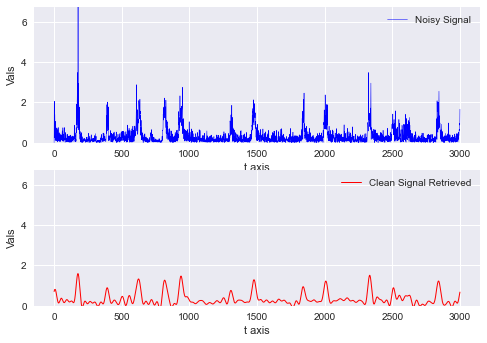

In [9]:
## Visualization
fig, ax = plt.subplots(2,1)
ax[0].plot(t, signal, color='b', lw=0.5, label='Noisy Signal')
# ax[0].plot(t, signal_clean, color='r', lw=1, label='Clean Signal')
ax[0].set_ylim([minsignal, maxsignal])
ax[0].set_xlabel('t axis')
ax[0].set_ylabel('Vals')
ax[0].legend()

ax[1].plot(t, signal_filtered.real, color='r', lw=1, label='Clean Signal Retrieved')
ax[1].set_ylim([minsignal, maxsignal])
ax[1].set_xlabel('t axis')
ax[1].set_ylabel('Vals')
ax[1].legend()

In [10]:
signal_filtered.real

array([0.7104547 , 0.73826435, 0.76234992, ..., 0.60931293, 0.64547371,
       0.67936215])

In [11]:
len(LC_2[:,-1])

3000

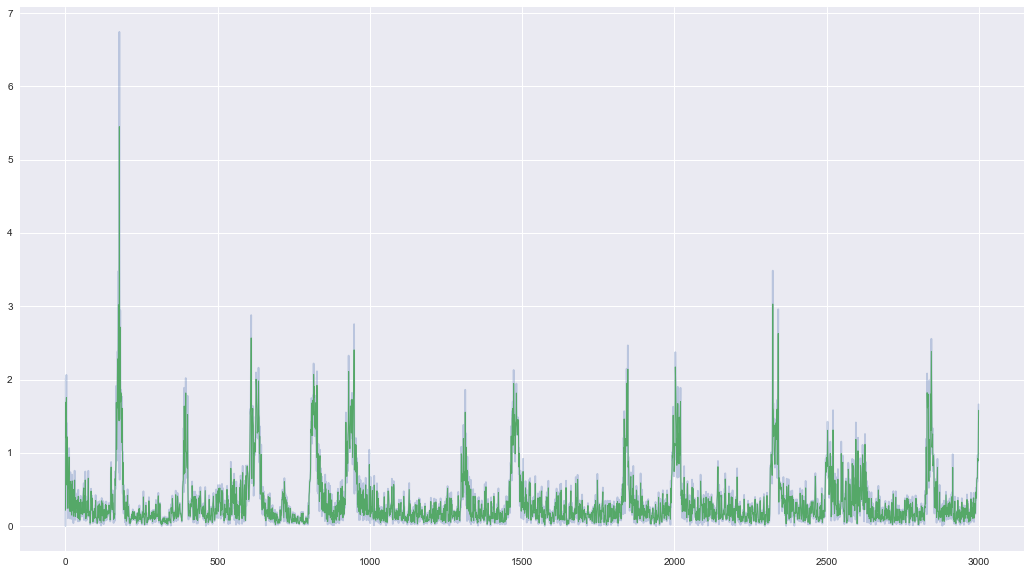

In [12]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
plt.plot(LC_2[:,-1],alpha=0.3)
plt.plot(gaussian_filter1d(LC_2[:,-1],sigma=0.5),lw=1)

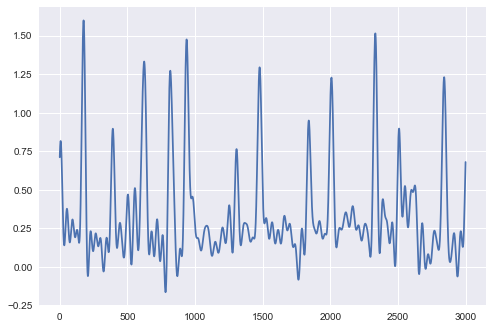

In [13]:
plt.plot(signal_filtered.real)

In [17]:
fft_gauss = gaussian_filter1d(signal_filtered.real,sigma=20)

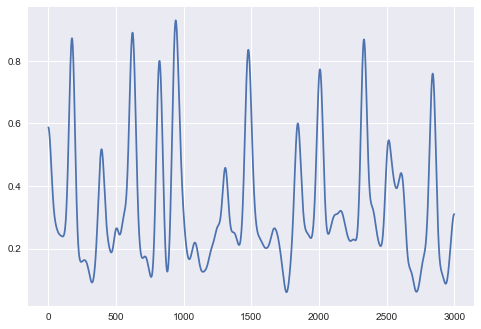

In [18]:
# plt.plot(signal_filtered.real)
plt.plot(fft_gauss)

<AxesSubplot:ylabel='Count'>

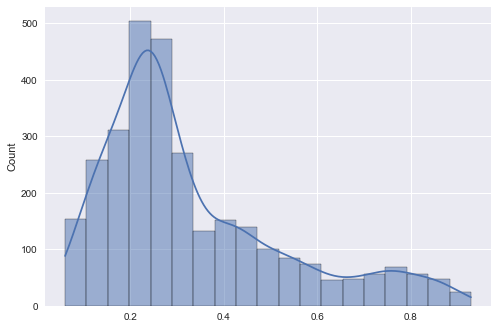

In [19]:
sns.histplot(fft_gauss,bins='scott',kde=True)

In [20]:
LC_01.shape

(3000, 6)

In [21]:
all_contrasts=[LC_01, LC_1, LC_2, LC_3, LC_5, LC_7, LC_10, RC_01, RC_1, RC_2, RC_3, RC_5, RC_7, RC_10]

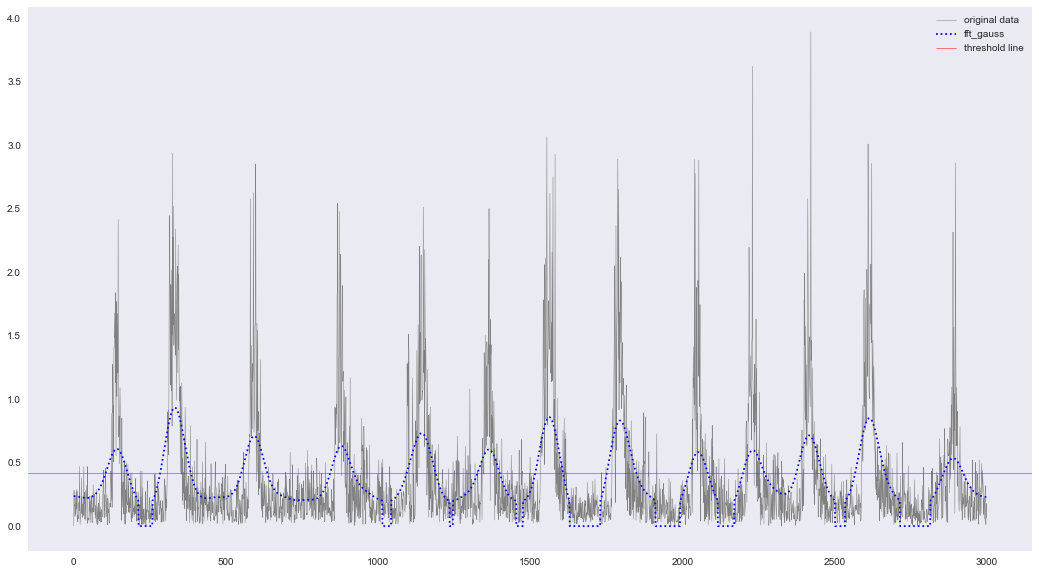

Threshold:  0.4176762133077776
Number of Peaks:  13


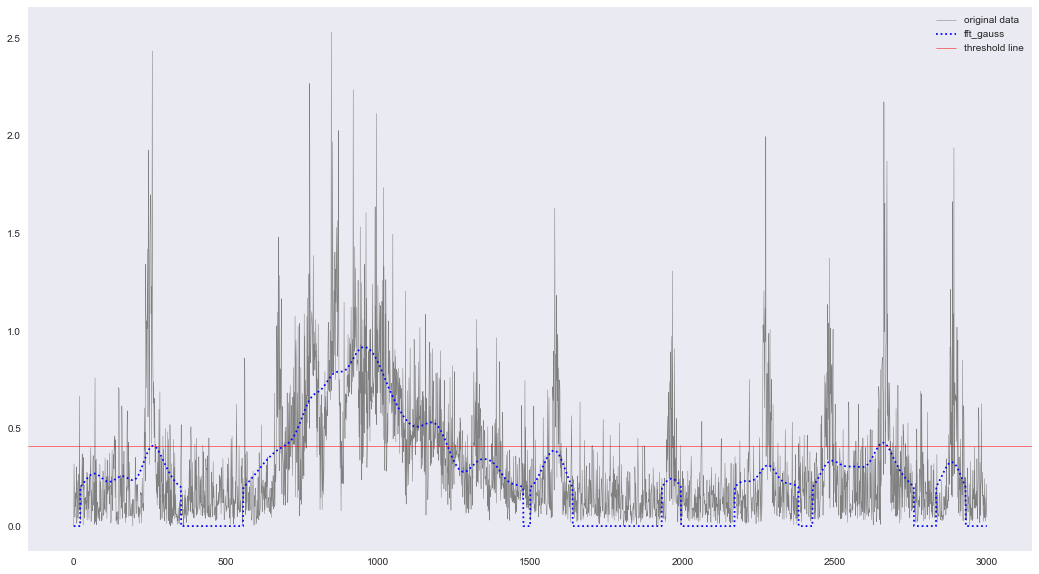

Threshold:  0.40982382053814315
Number of Peaks:  4


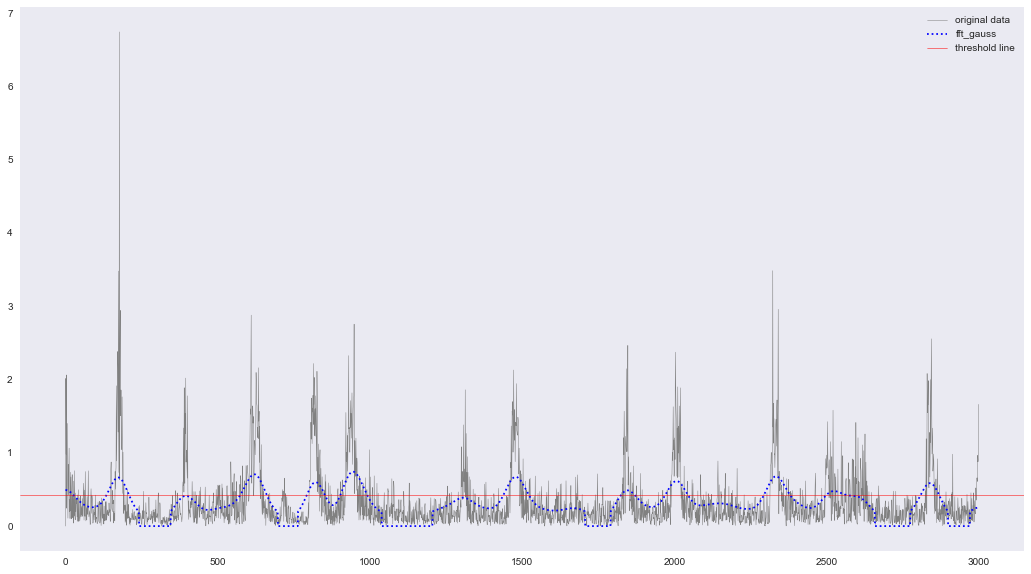

Threshold:  0.41872328026036054
Number of Peaks:  10


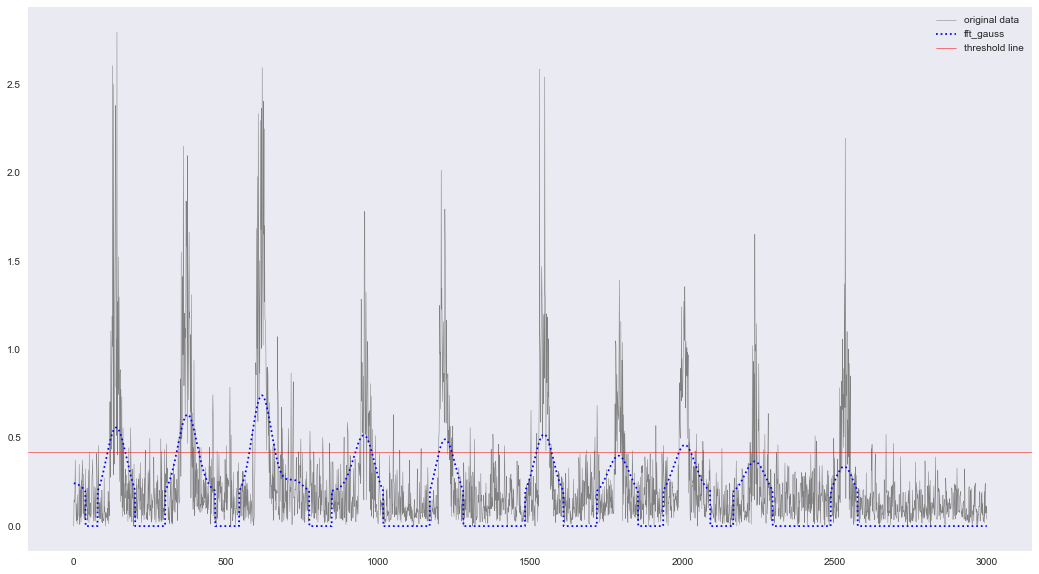

Threshold:  0.41708307779275533
Number of Peaks:  7


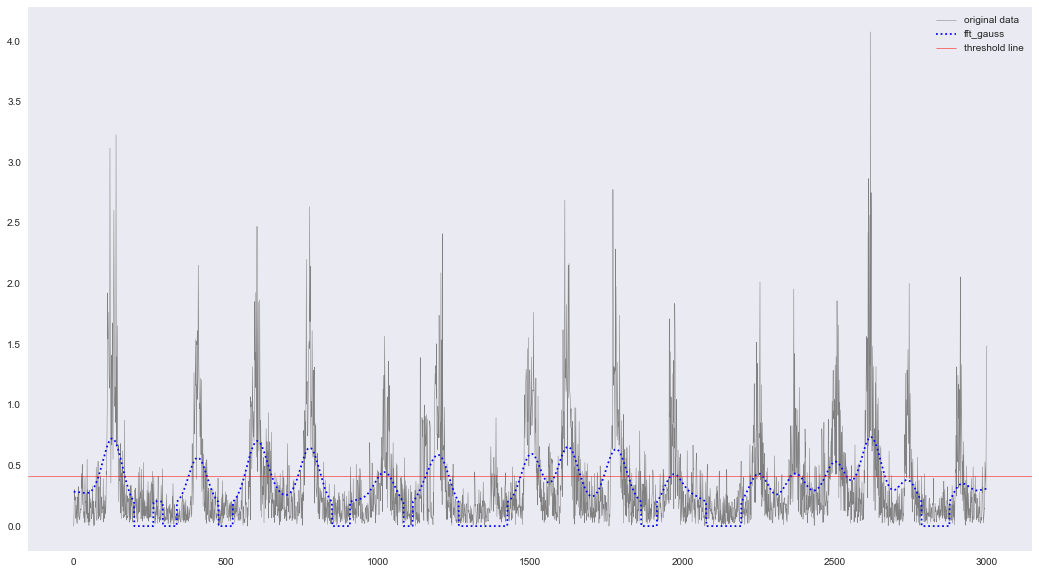

Threshold:  0.41626790053804075
Number of Peaks:  14


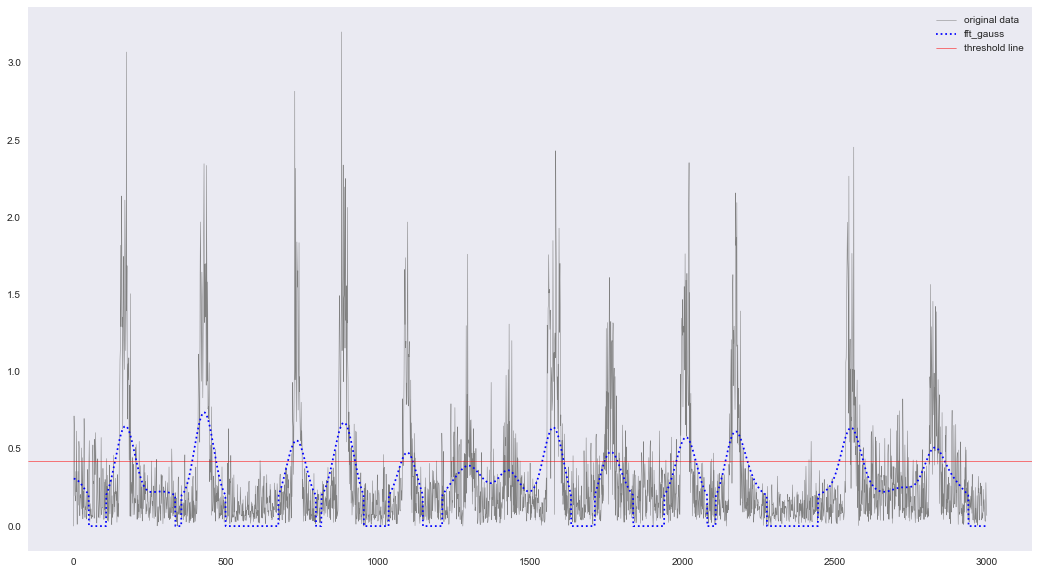

Threshold:  0.4207740118823814
Number of Peaks:  11


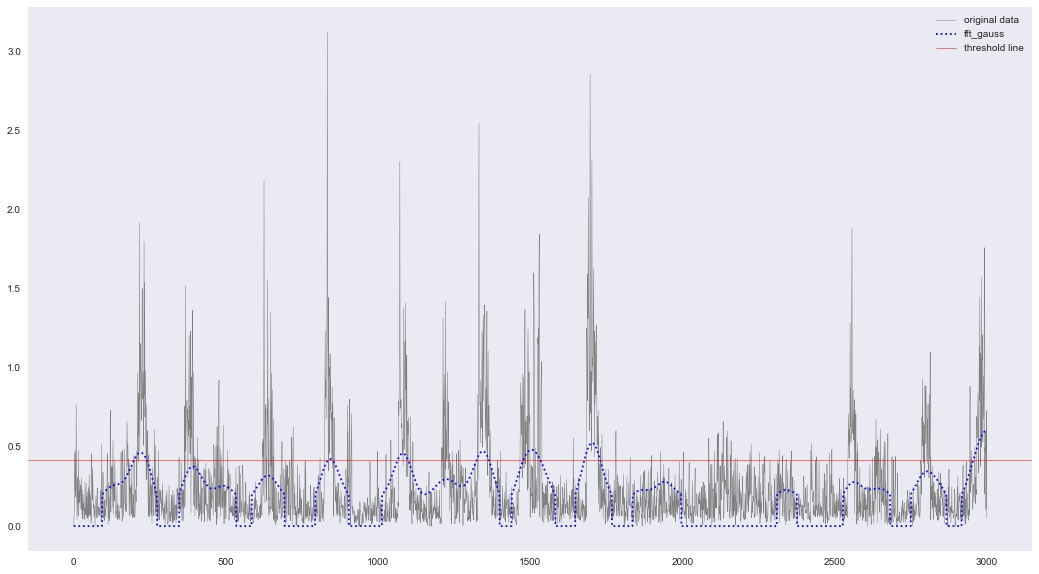

Threshold:  0.41972419286519136
Number of Peaks:  6


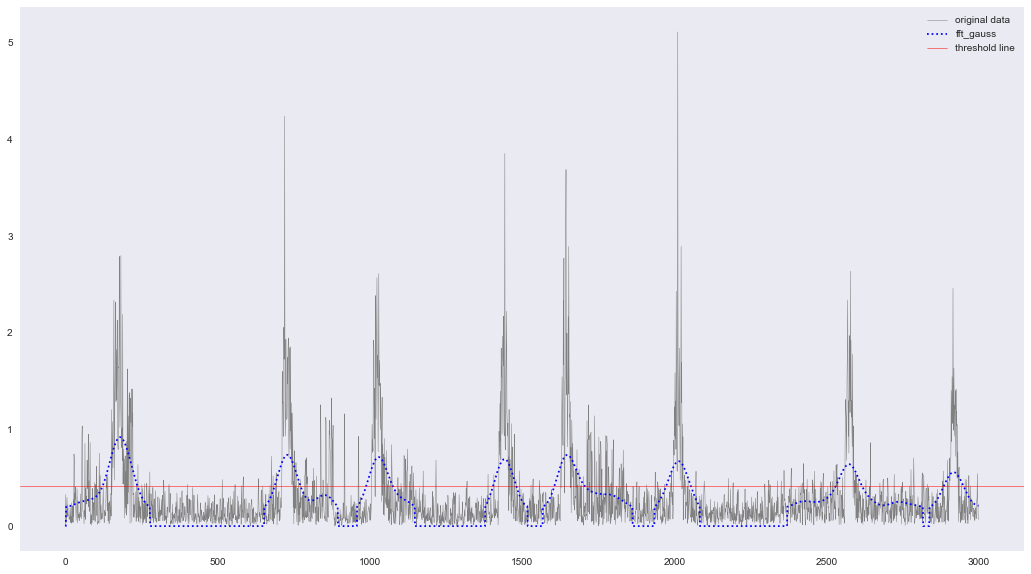

Threshold:  0.41855443453811303
Number of Peaks:  8


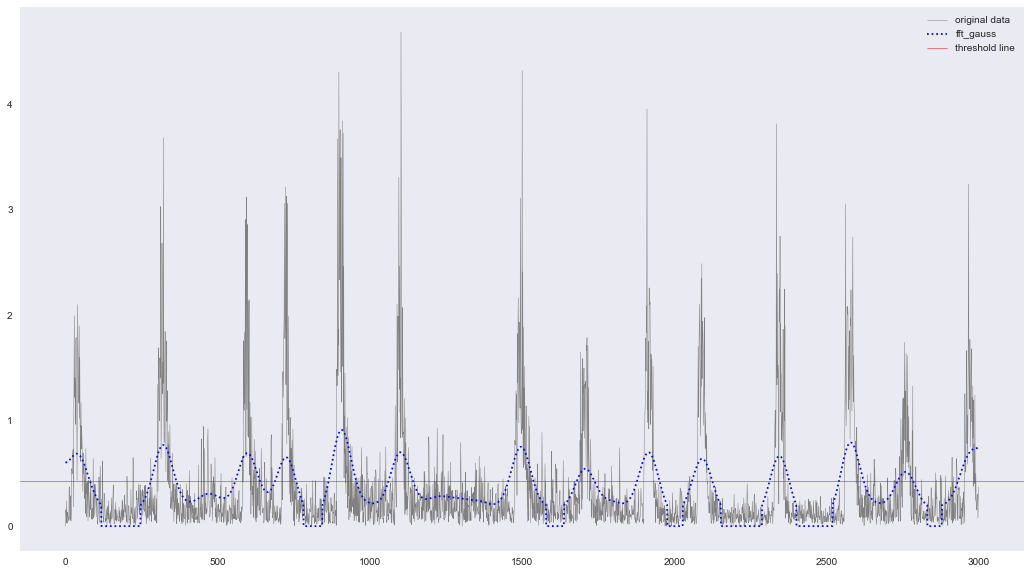

Threshold:  0.4260602104688046
Number of Peaks:  13


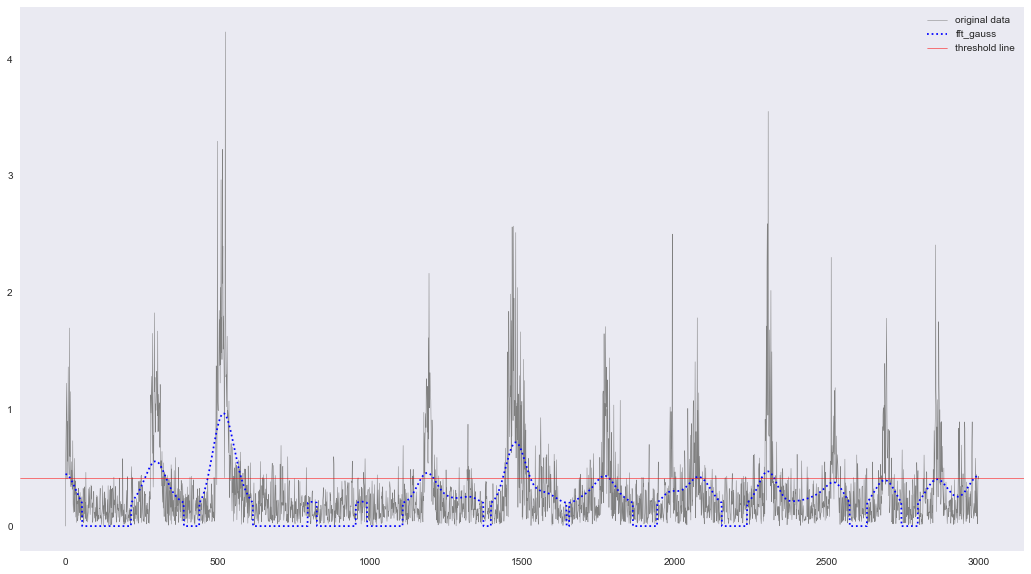

Threshold:  0.4128441615836274
Number of Peaks:  7


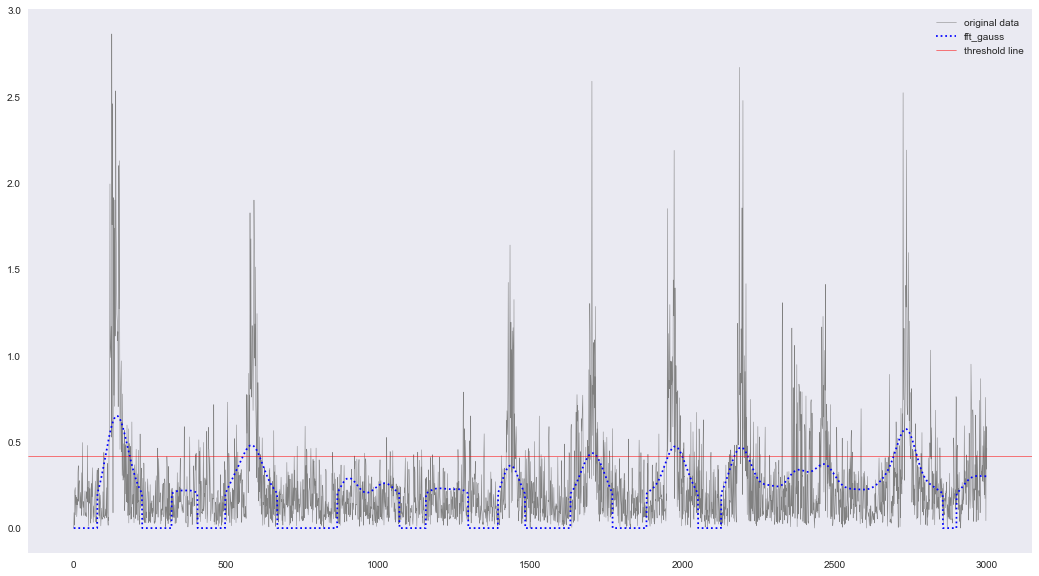

Threshold:  0.41470394939995836
Number of Peaks:  6


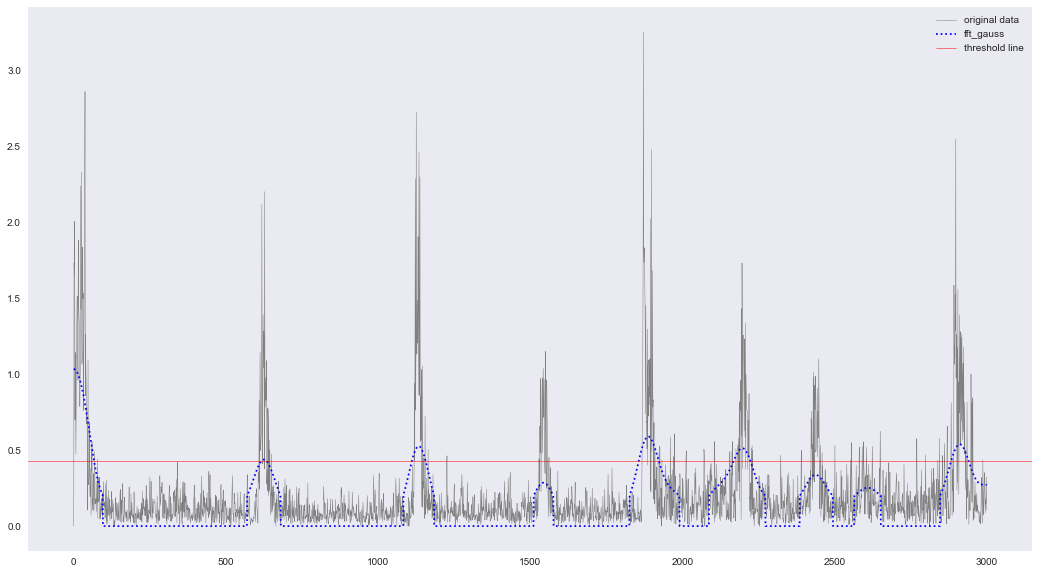

Threshold:  0.4263669574428476
Number of Peaks:  5


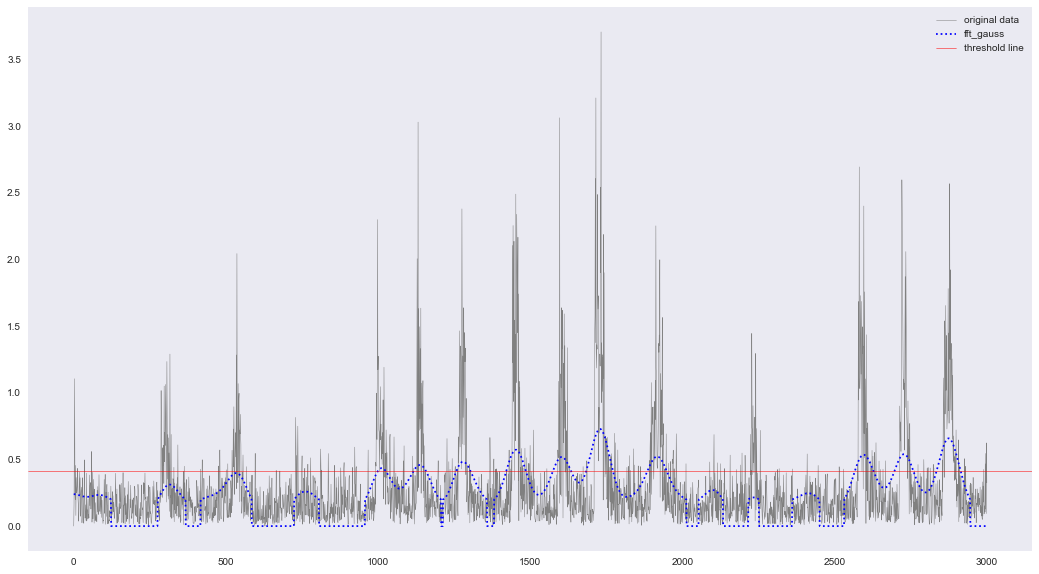

Threshold:  0.4124539225878603
Number of Peaks:  10


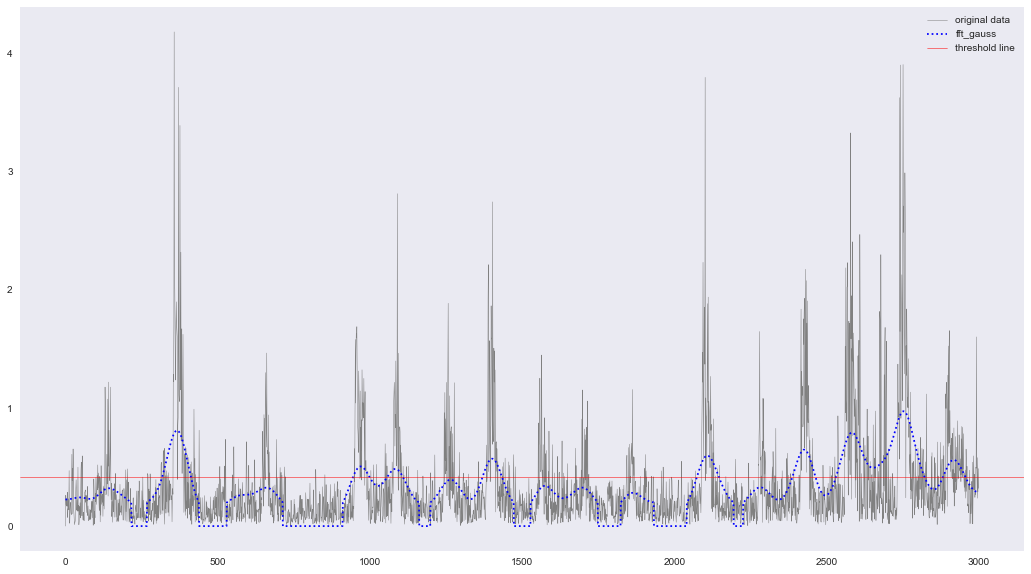

Threshold:  0.4144861932508207
Number of Peaks:  9


In [22]:
for contrast in all_contrasts:    
    fish_distance = contrast[:,-1]
    if np.sum(np.isnan(fish_distance)) > 0:
        np.nan_to_num(fish_distance,copy=False,nan=0)

    t = np.arange(0, 3000, 1)
    signal = fish_distance #composite signal
    signal_clean = signal #copy for later comparison
    minsignal, maxsignal = signal.min(), signal.max()

    ## Compute Fourier Transform
    n = len(t)
    fhat = np.fft.fft(signal, n) #computes the fft
    psd = fhat * np.conj(fhat)/n
    freq = (1/(1*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index

    ## Filter out noise
    threshold = 1
    psd_idxs = psd > threshold #array of 0 and 1
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal

    signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

    fft_signal = signal_filtered.real
    fft_gauss = gaussian_filter1d(fft_signal,sigma=30)

    fish_distance_2 = []
    for frame in fft_gauss:
        if frame<=0.2:
            frame=0
        fish_distance_2.append(frame)
    fft_gauss = fish_distance_2

    # Differentiating the smoothed distance
    derivative = np.gradient(fft_gauss,edge_order=1)

    # Smoothing the derivative
    # smooth_derivative = gaussian_filter1d(derivative,sigma=1)

    # Creating a histogram of smooth derivative 
    hist, bin_edges = np.histogram(derivative,bins='scott')

    threshold = (bin_edges[-1]-(bin_edges[0]))*2

    fig, ax = plt.subplots(1,1,figsize=(18,10))
    ax.plot(fish_distance, 'gray', lw=0.5, label='original data')
    ax.plot(fft_gauss, ':', color='b',label='fft_gauss')
    ax.axhline(y=threshold, color='r', linestyle='-',lw=0.5,label='threshold line')
    ax.legend()
    ax.grid()
    plt.show()

    peaks = find_peaks(fft_gauss,height=threshold)

    print('Threshold: ',threshold)
    print('Number of Peaks: ',len(peaks[0]))

In [23]:
from scipy import signal
import matplotlib.pyplot as plt

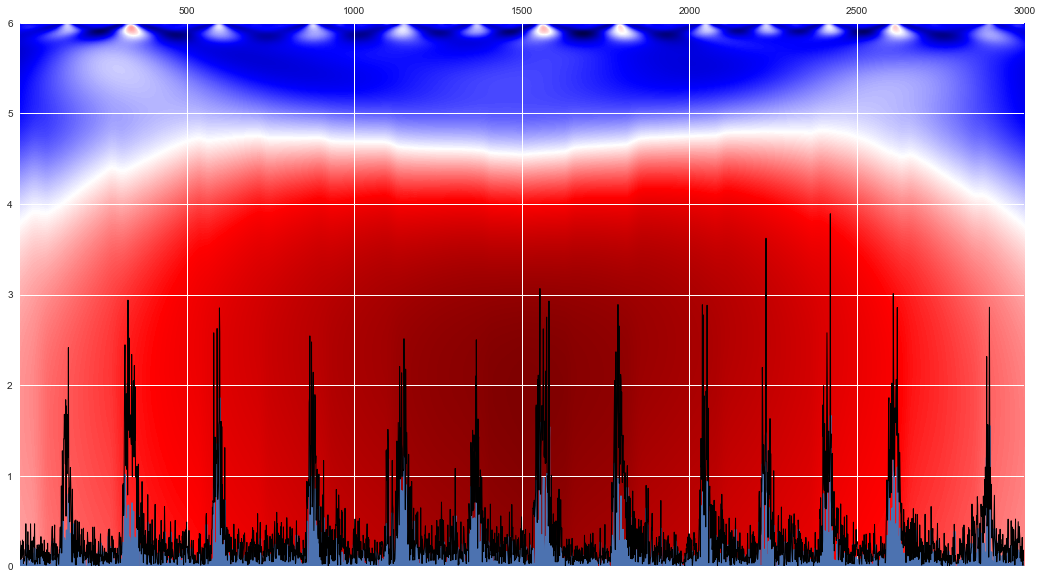

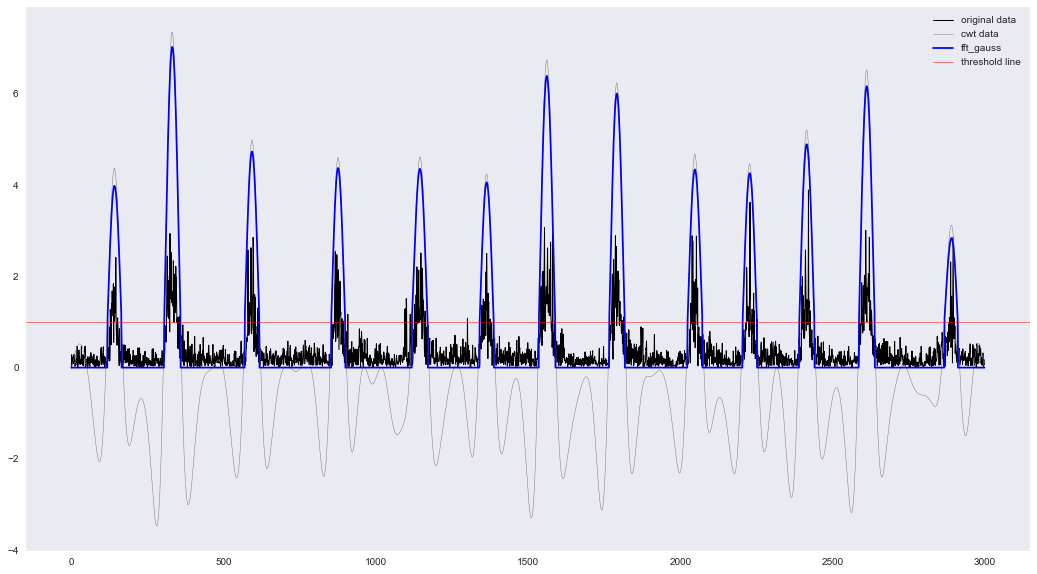

Number of Peaks:  13


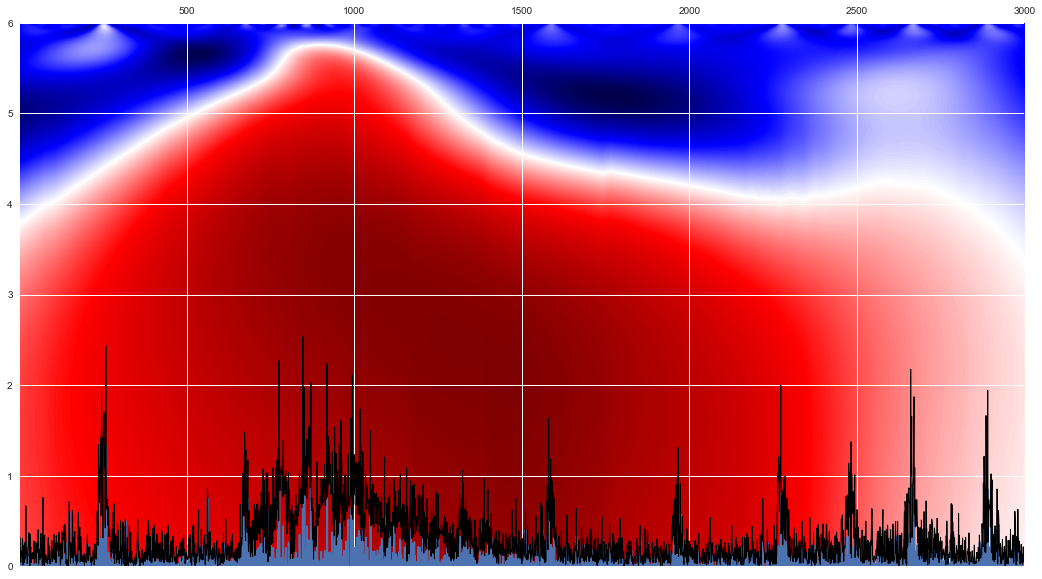

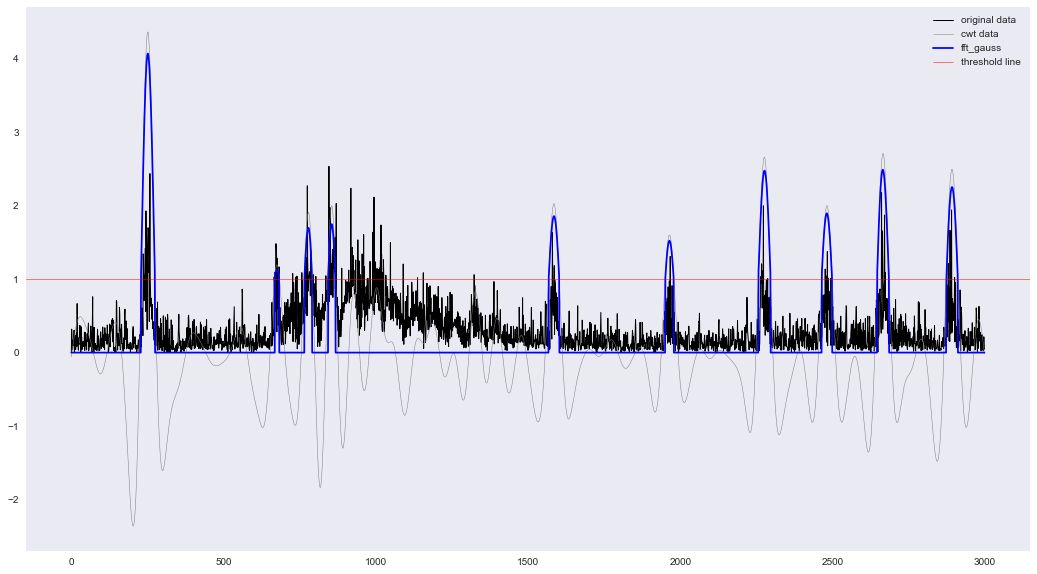

Number of Peaks:  10


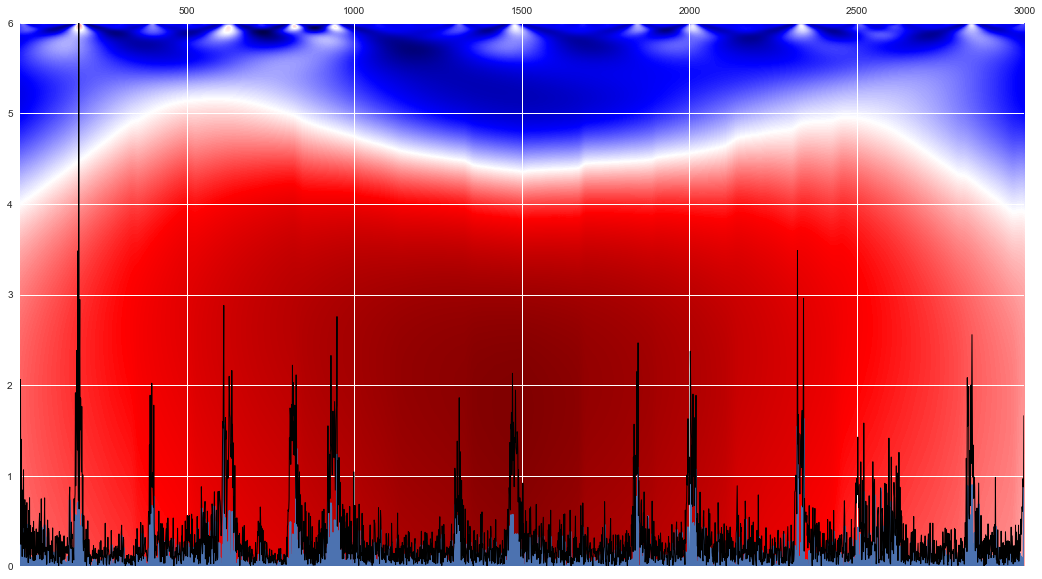

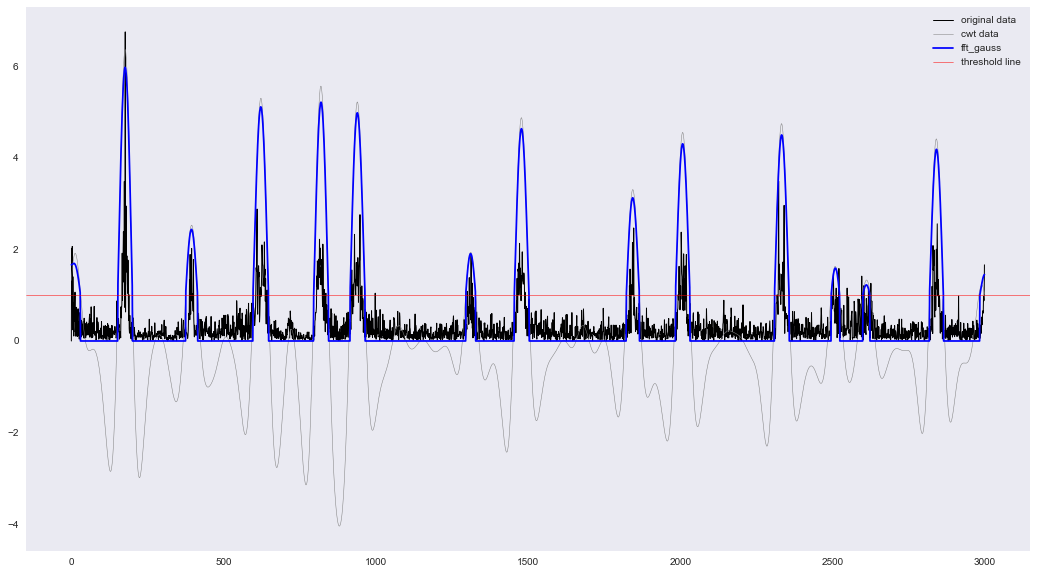

Number of Peaks:  14


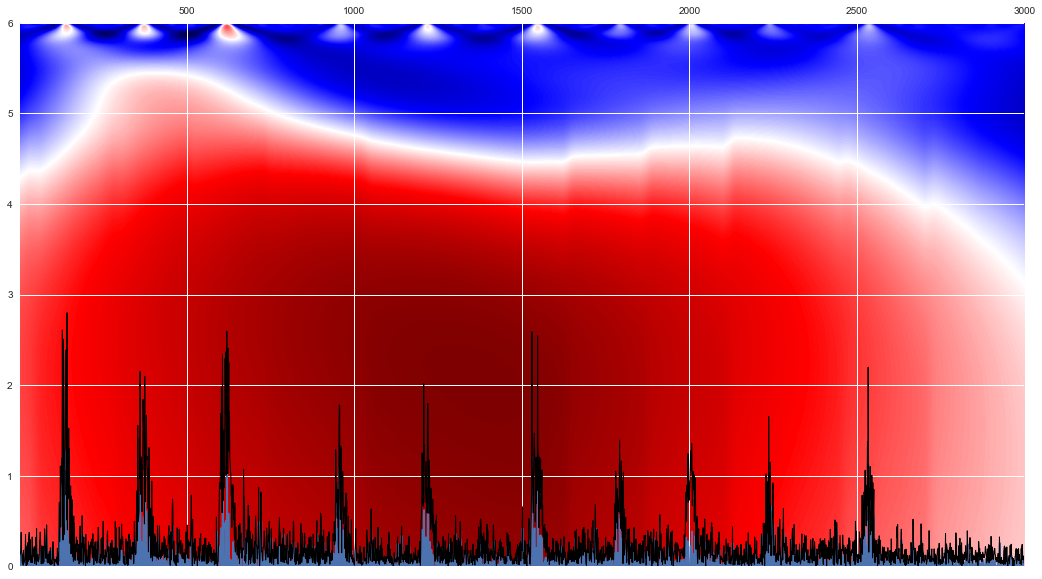

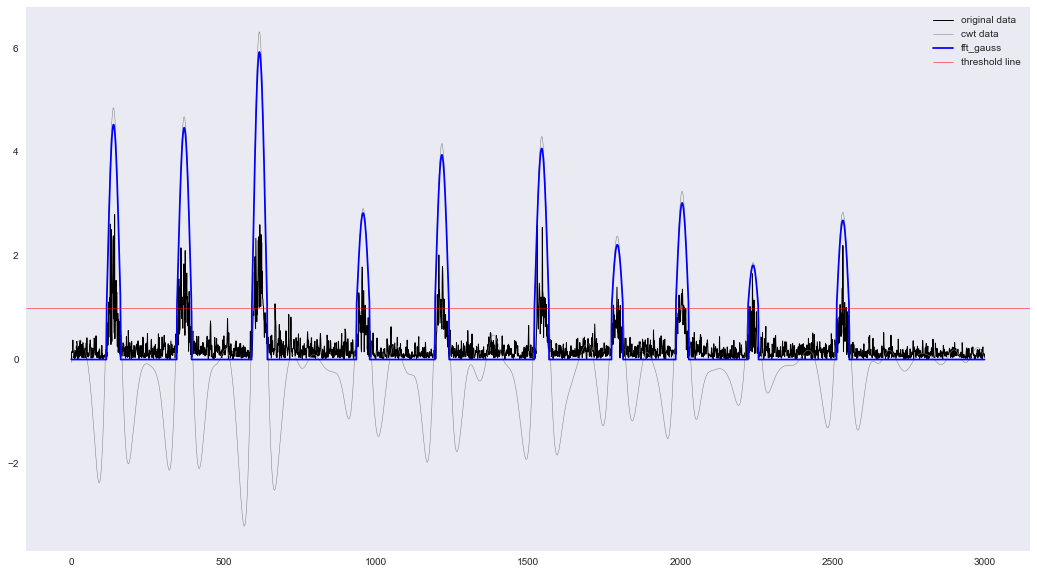

Number of Peaks:  10


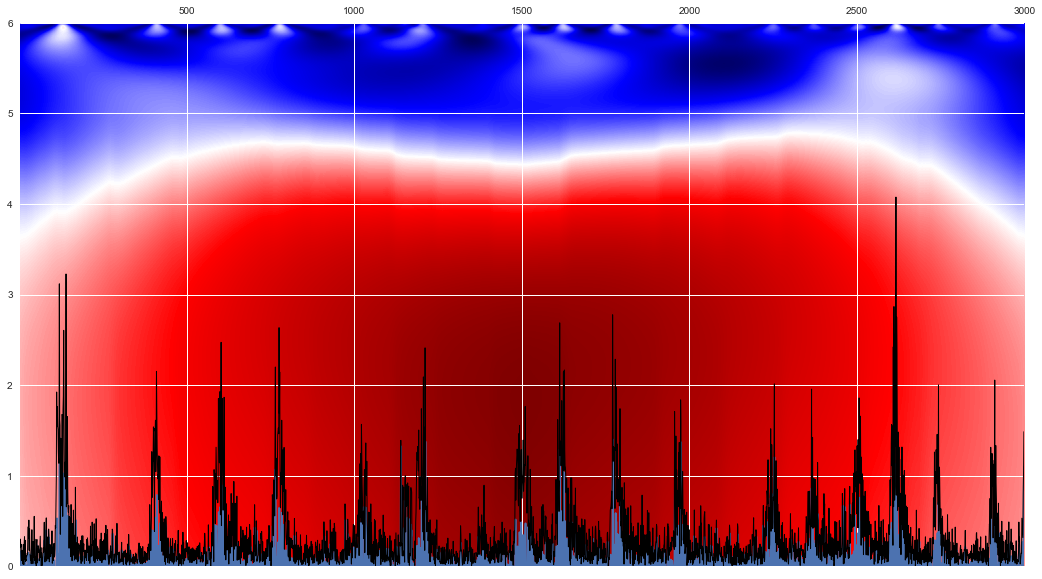

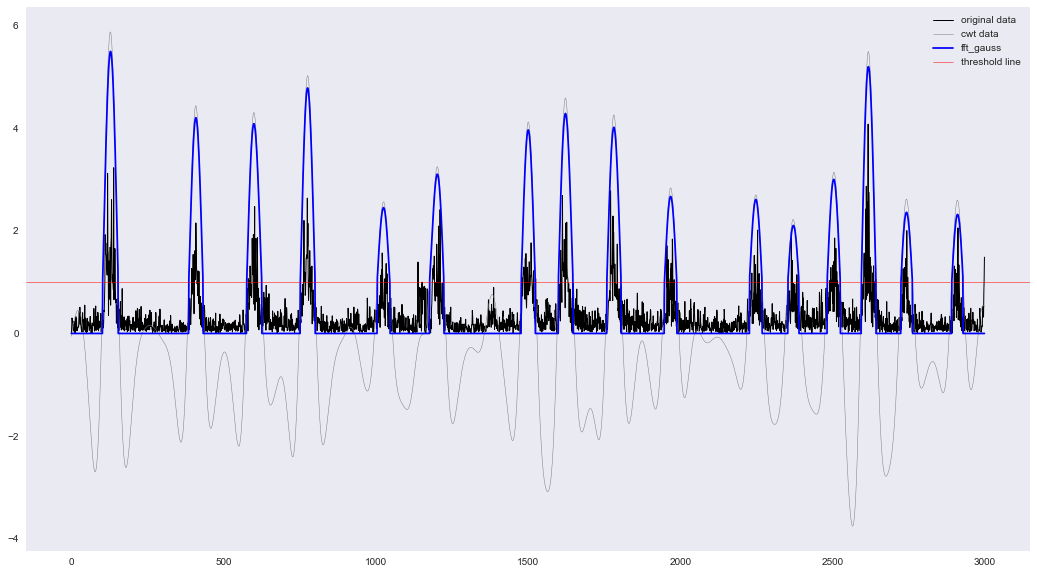

Number of Peaks:  16


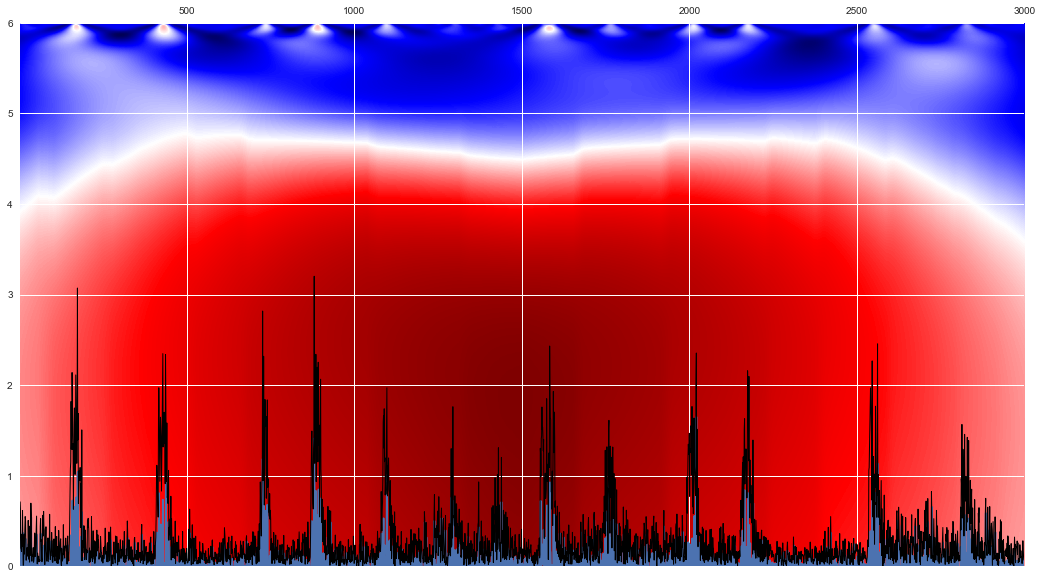

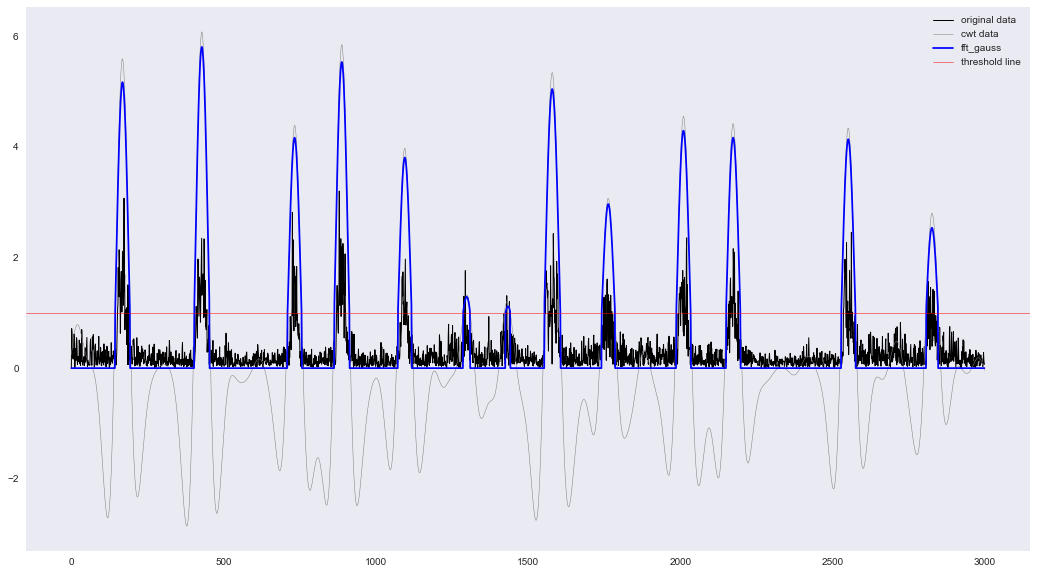

Number of Peaks:  13


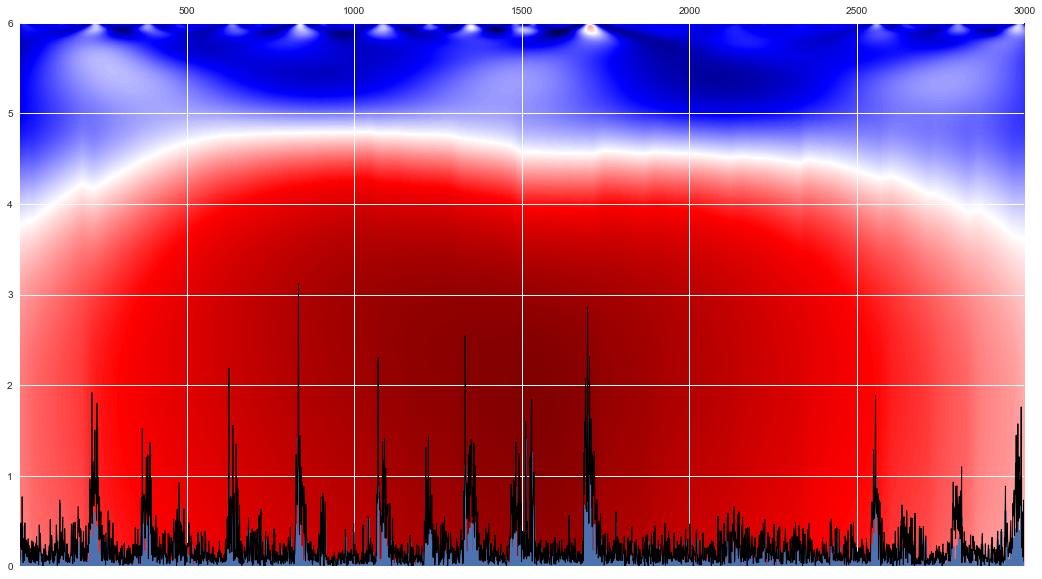

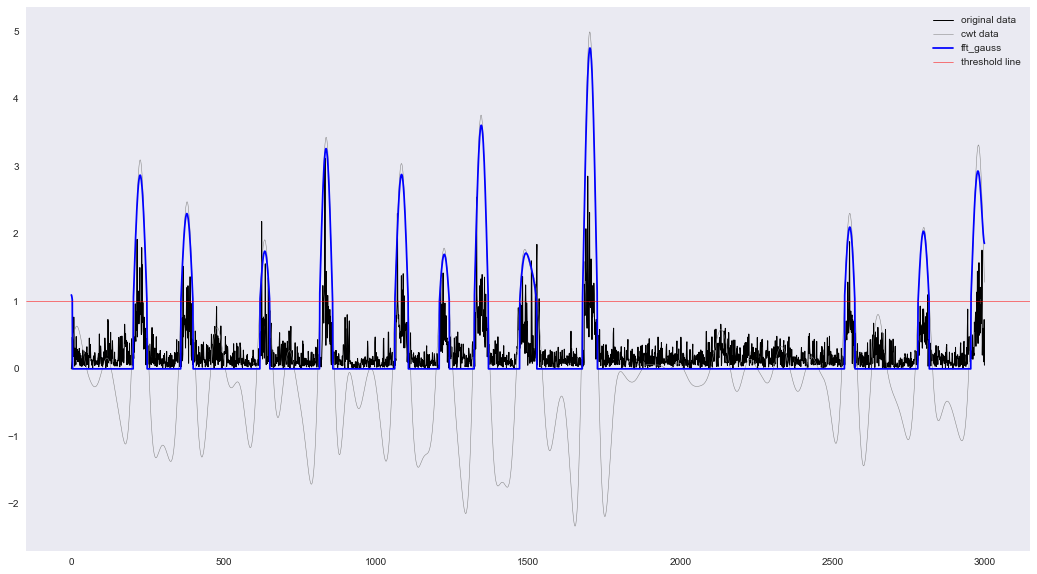

Number of Peaks:  12


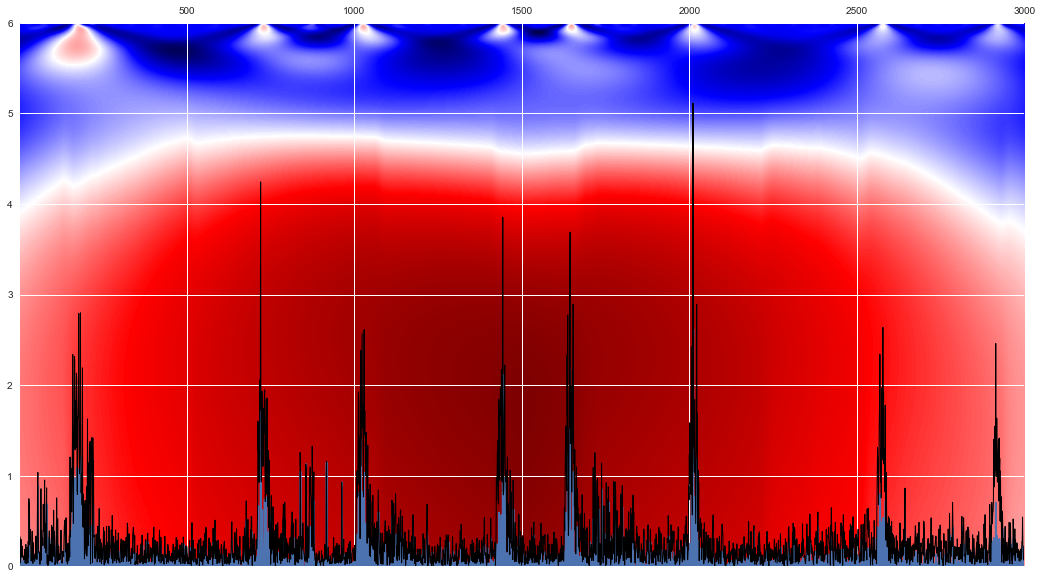

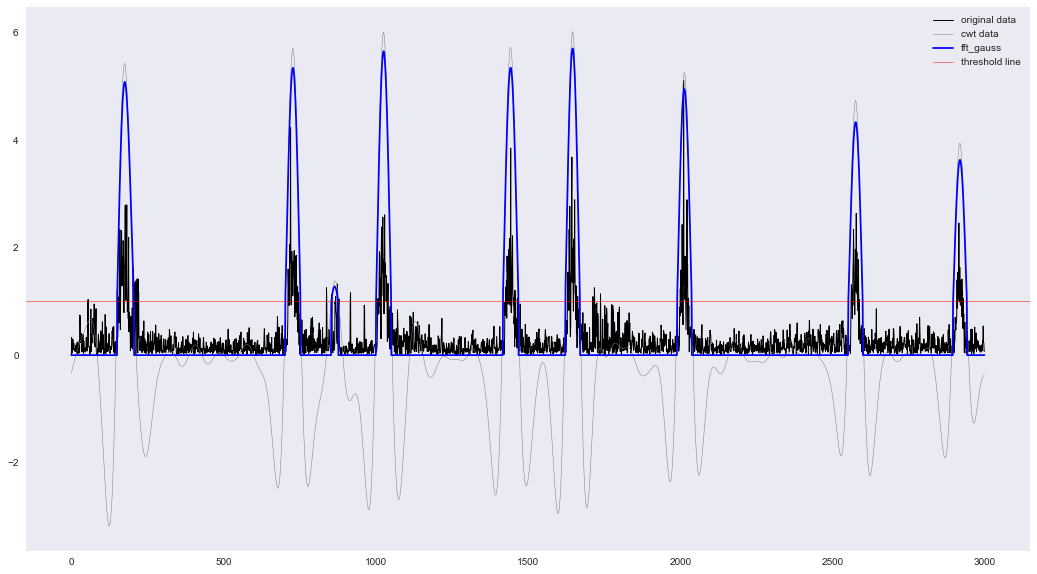

Number of Peaks:  9


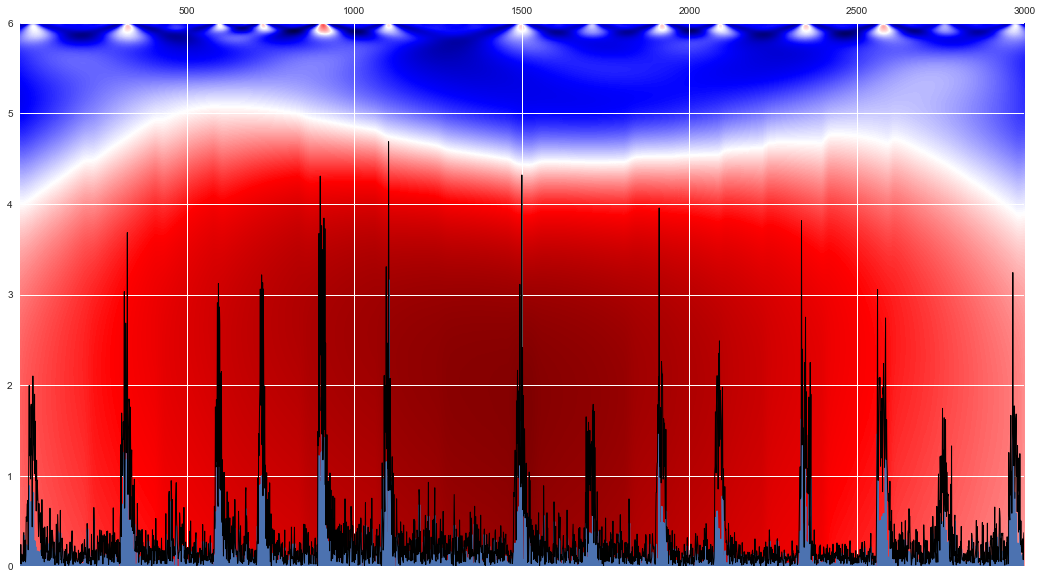

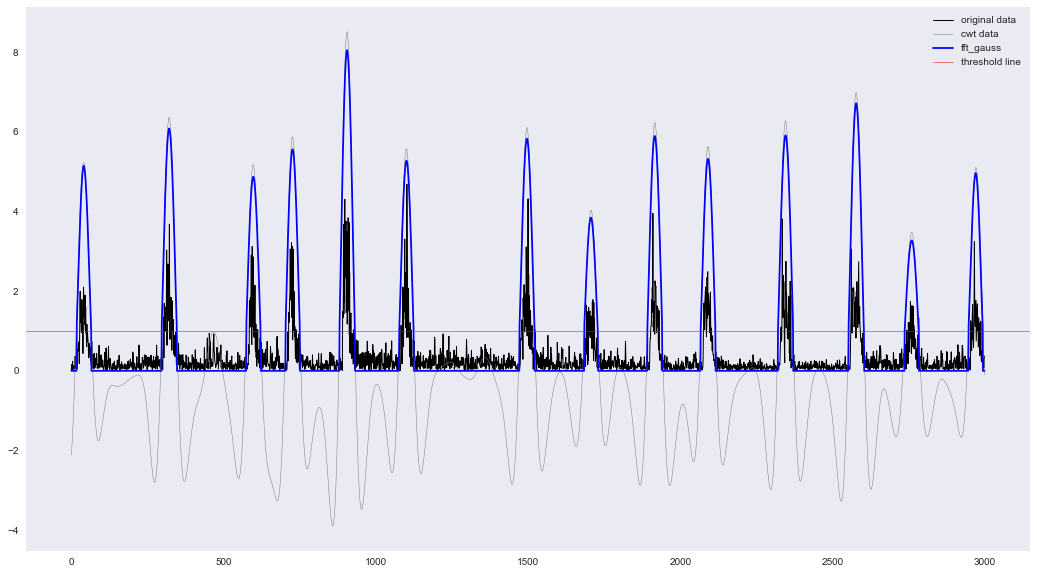

Number of Peaks:  14


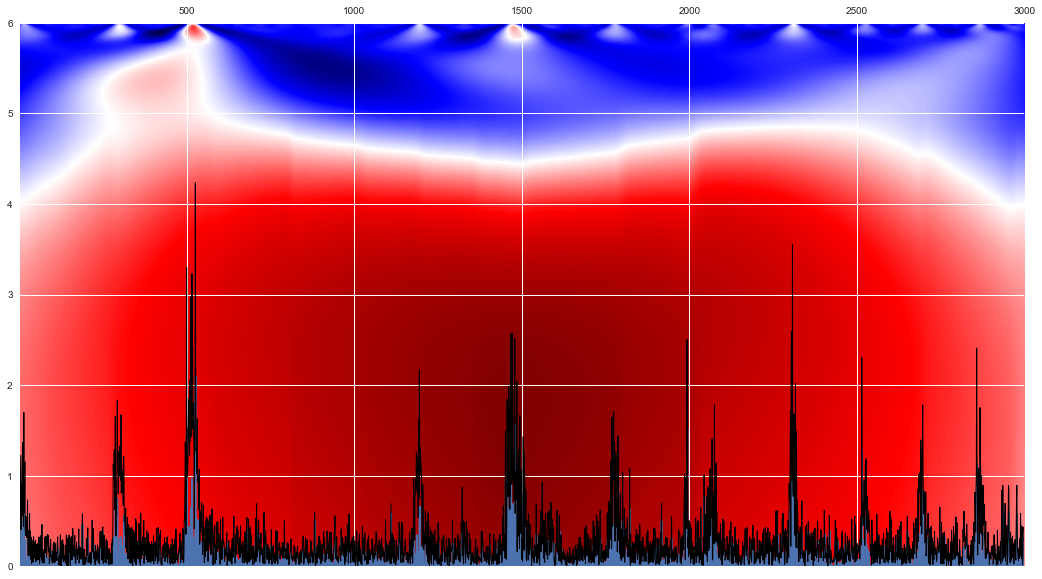

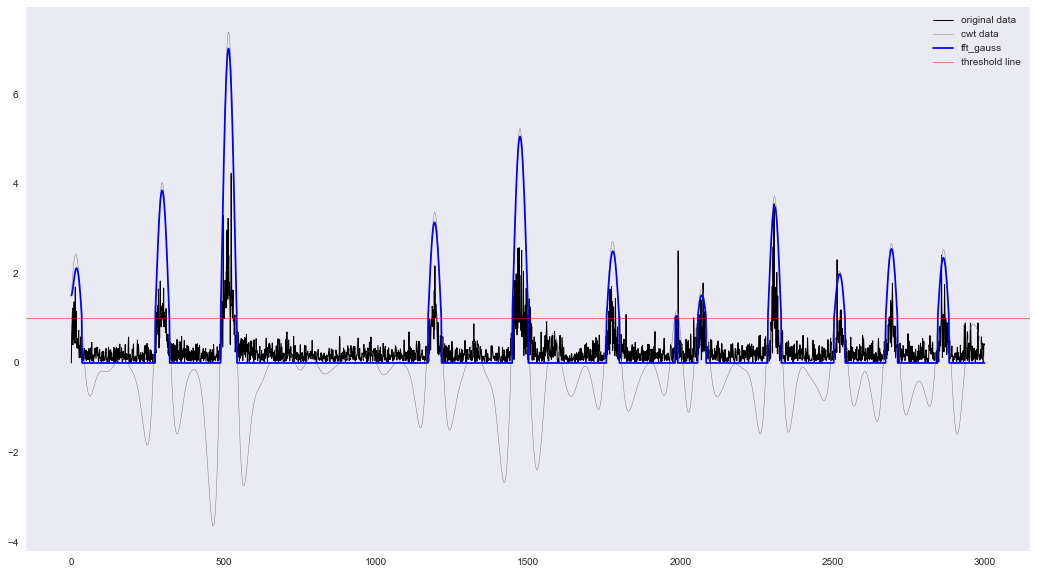

Number of Peaks:  12


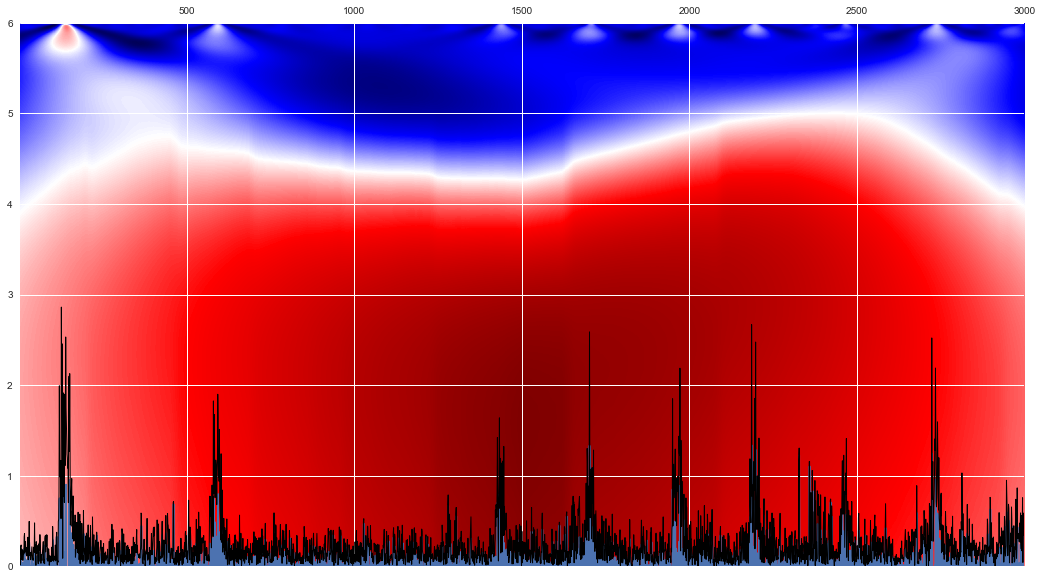

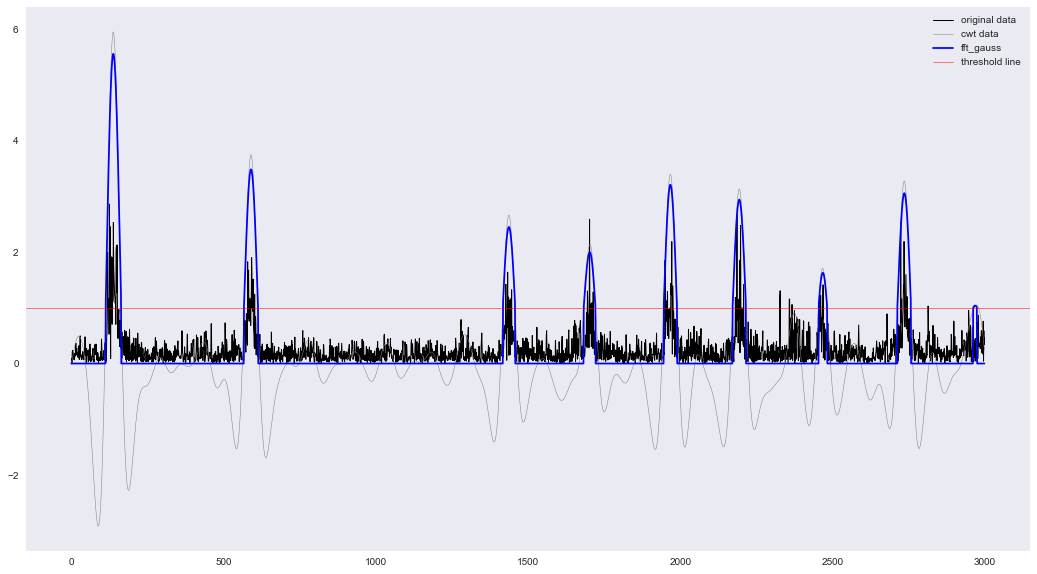

Number of Peaks:  9


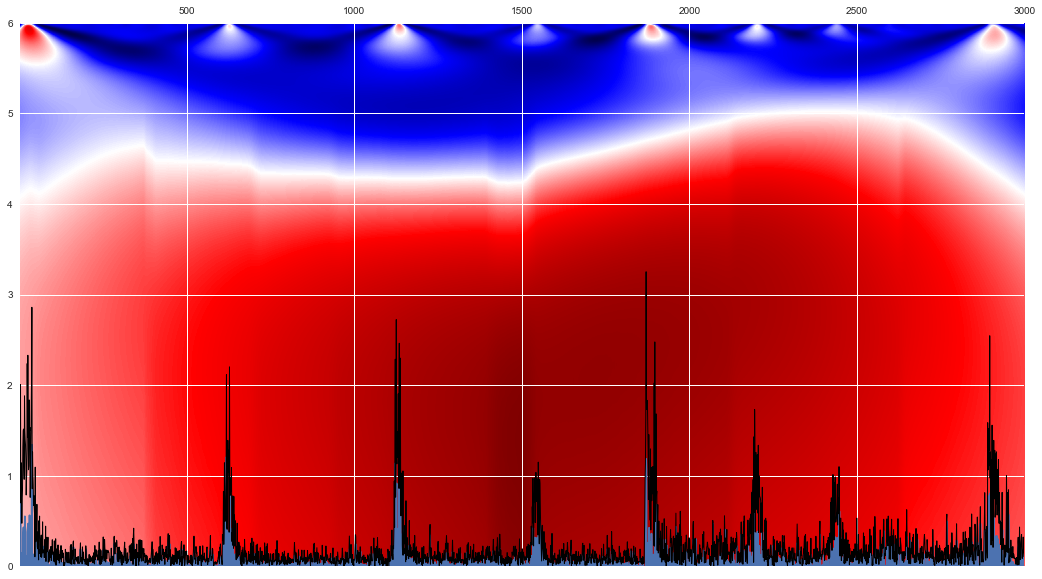

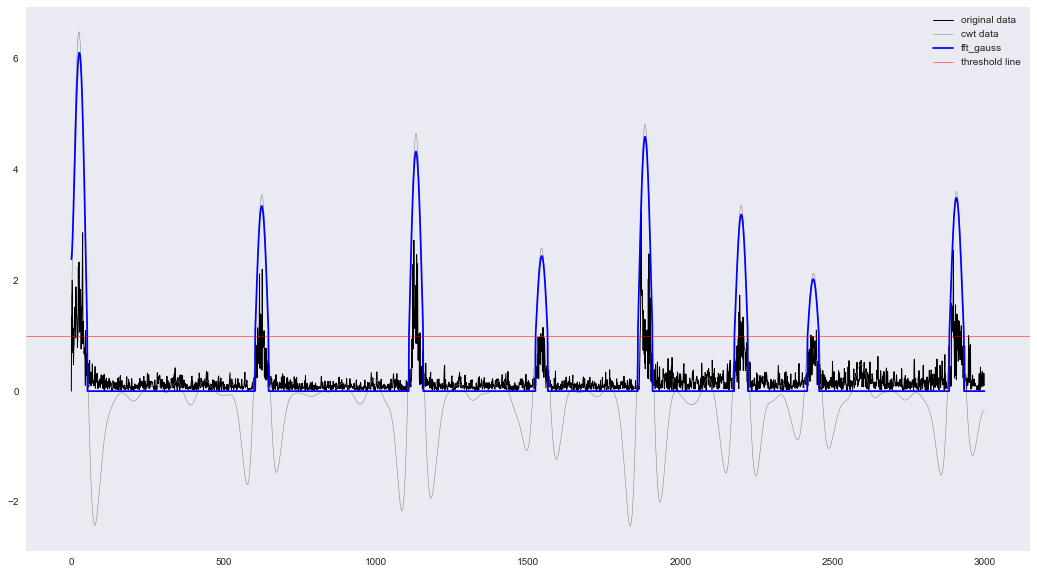

Number of Peaks:  8


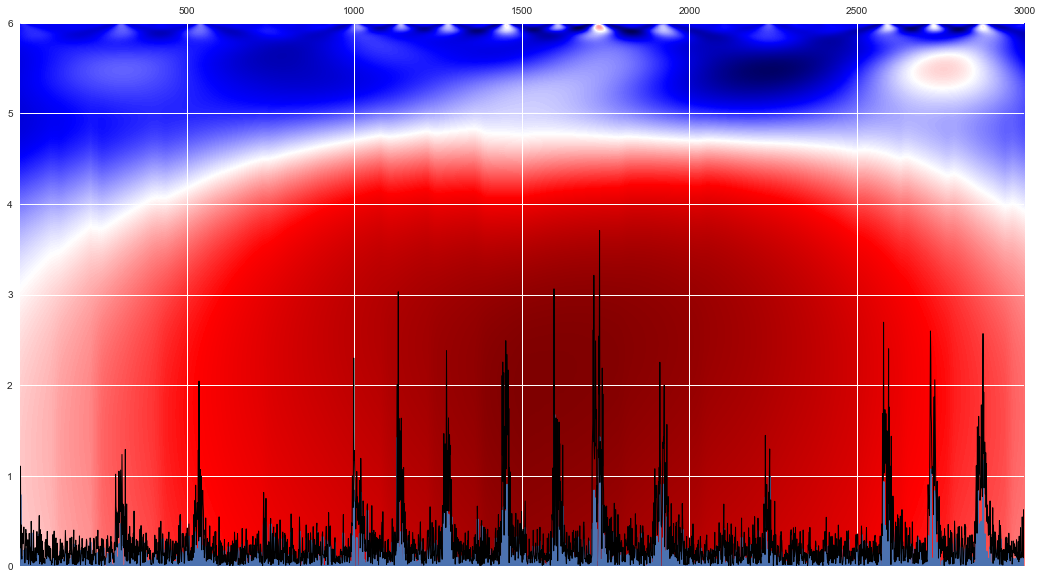

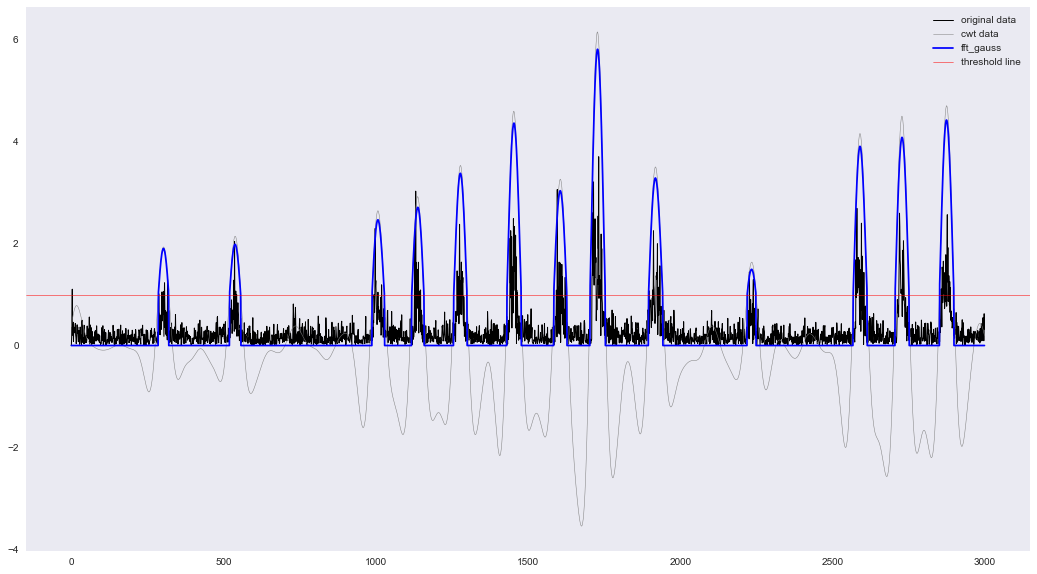

Number of Peaks:  13


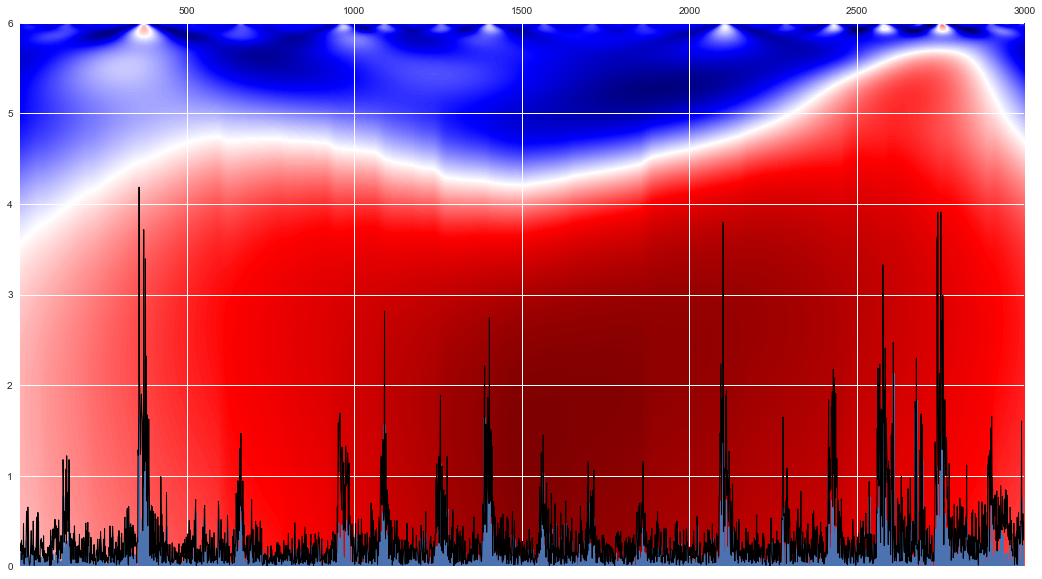

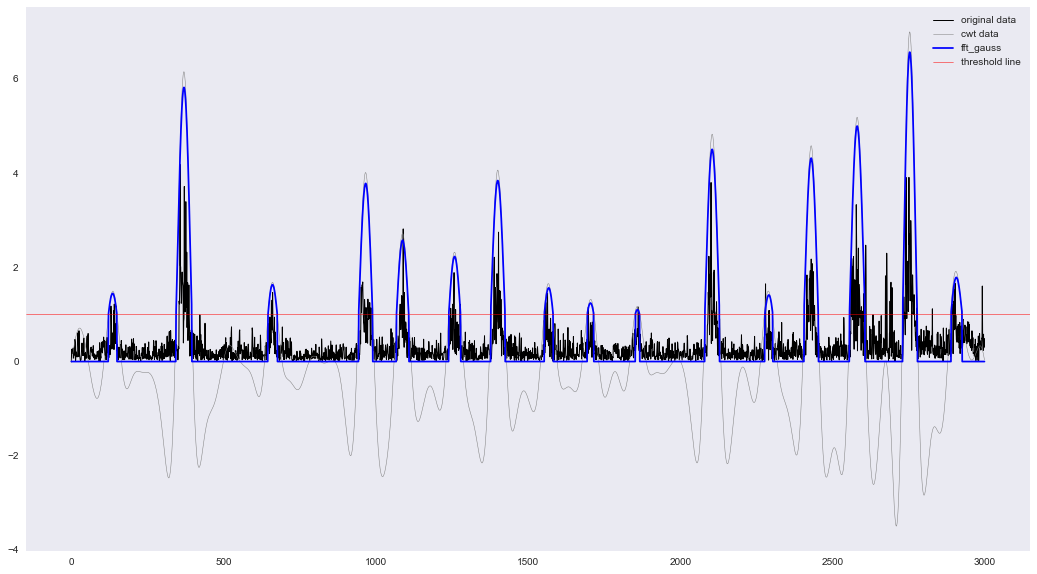

Number of Peaks:  16


In [28]:
all_contrasts=[LC_01, LC_1, LC_2, LC_3, LC_5, LC_7, LC_10, RC_01, RC_1, RC_2, RC_3, RC_5, RC_7, RC_10]
for contrast in all_contrasts:    
    fish_distance = contrast[:,-1]
    if np.sum(np.isnan(fish_distance)) > 0:
        np.nan_to_num(fish_distance,copy=False,nan=0)

    t = np.arange(0, 3000, 1)
    sig = fish_distance #composite signal
    sig_clean = signal #copy for later comparison
    minsignal, maxsignal = sig.min(), sig.max()

    widths = np.arange(1, 3000)
    cwtmatr = signal.cwt(sig, signal.ricker, widths)
    fig, ax = plt.subplots(1,1,figsize=(18,10))
    ax.plot(cwtmatr[0,:])
    ax.plot(sig,'k',lw=1)
    ax.matshow(cwtmatr.real, extent=[1, 3000, 0, 6], cmap='seismic', aspect='auto',interpolation='nearest')
    plt.show()
    
    t = np.arange(0, 3000, 1)
    cwt_sig = cwtmatr[25,:] #composite signal
    signal_clean = sig #copy for later comparison
    minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()

    ## Compute Fourier Transform
    n = len(t)
    fhat = np.fft.fft(cwt_sig, n) #computes the fft
    psd = fhat * np.conj(fhat)/n
    freq = (1/(1*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index

    ## Filter out noise
    threshold = 1
    psd_idxs = psd > threshold #array of 0 and 1
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal

    signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

    fft_signal = signal_filtered.real
    fft_gauss = gaussian_filter1d(fft_signal,sigma=5)

    fish_distance_2 = []
    for frame in fft_gauss:
        if frame<=1:
            frame=0
        fish_distance_2.append(frame)
    fft_gauss = fish_distance_2

    fig, ax = plt.subplots(1,1,figsize=(18,10))
    ax.plot(sig,'k',lw=1,label='original data')
    ax.plot(cwt_sig, 'gray', lw=0.5, label='cwt data')
    ax.plot(fft_gauss, '-', color='b',label='fft_gauss')
    ax.axhline(y=1, color='r', linestyle='-',lw=0.5,label='threshold line')
    ax.legend()
    ax.grid()
    plt.show()

    peaks = find_peaks(fft_gauss,height=1)

    print('Number of Peaks: ',len(peaks[0]))

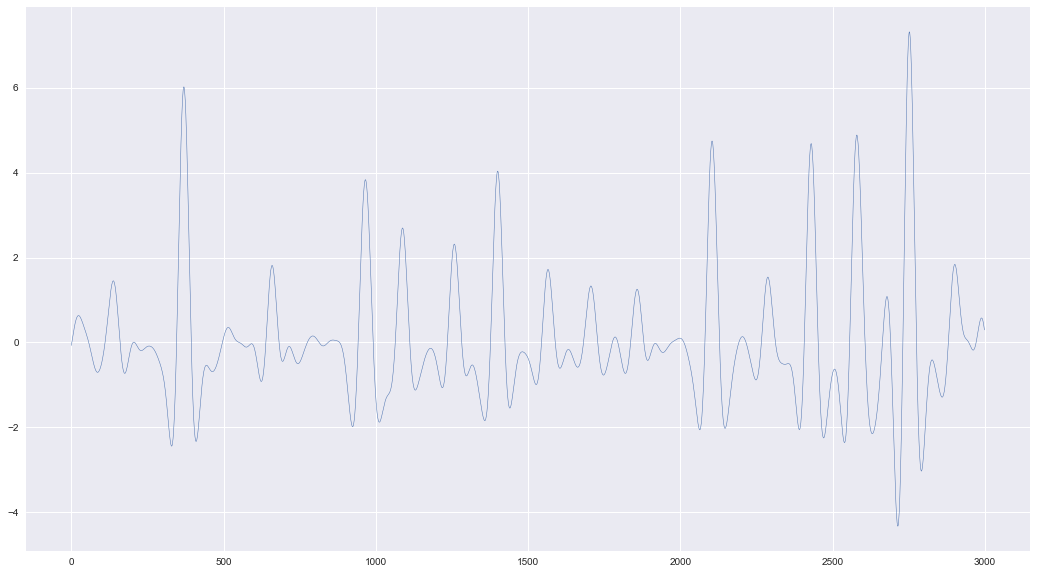

In [25]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
plt.plot(cwtmatr[20,:],lw=0.5)
# plt.plot(RC_01[:,-1],lw=0.5)

In [1]:
t = np.arange(0, 3000, 1)
sig = cwtmatr[25,:] #composite signal
signal_clean = sig #copy for later comparison
minsignal, maxsignal = sig.min(), sig.max()

## Compute Fourier Transform
n = len(t)
fhat = np.fft.fft(sig, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq = (1/(1*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index

## Filter out noise
threshold = 1
psd_idxs = psd > threshold #array of 0 and 1
psd_clean = psd * psd_idxs #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

fft_signal = signal_filtered.real
fft_gauss = gaussian_filter1d(fft_signal,sigma=5)

fish_distance_2 = []
for frame in fft_gauss:
    if frame<=1:
        frame=0
    fish_distance_2.append(frame)
fft_gauss = fish_distance_2

fig, ax = plt.subplots(1,1,figsize=(18,10))
ax.plot(sig, 'gray', lw=0.5, label='original data')
ax.plot(fft_gauss, '-', color='b',label='fft_gauss')
ax.axhline(y=1, color='r', linestyle='-',lw=0.5,label='threshold line')
ax.legend()
ax.grid()
plt.show()

peaks = find_peaks(fft_gauss,height=1)

# print('Threshold: ',threshold)
print('Number of Peaks: ',len(peaks[0]))

NameError: name 'np' is not defined

In [27]:
pd.DataFrame(fft_gauss).head(30)

0
0   0.224494
1   0.227499
2   0.233425
3   0.242111
4   0.253336
5   0.266831
6   0.282305
7   0.299454
8   0.317982
9   0.337605
10  0.358057
11  0.379089
12  0.400473
13  0.421991
14  0.443439
15  0.464621
16  0.485346
17  0.505432
18  0.524700
19  0.542977
20  0.560100
21  0.575908
22  0.590255
23  0.603002
24  0.614020
25  0.623195
26  0.630424
27  0.635618
28  0.638702
29  0.639616